In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

In [53]:
# --- 1. Load and Initial Cleanup ---
df = pd.read_csv("stud_data.csv")
df = df.drop_duplicates()
print("[INFO] Raw data loaded:")
print(df.head())

[INFO] Raw data loaded:
       Name  Hours_Studied  Previous_Sem_Percentage  Phone_Usage_Hrs  \
0  Aadhya 1            5.0                     82.0              1.0   
1   Meera 2            2.0                     81.0              9.0   
2   Anika 3            6.0                     53.0              7.0   
3  Saanvi 4            3.0                     66.0              4.0   
4   Aarav 5            5.0                     48.0              NaN   

   Test_Anxiety_Level  Subject_Difficulty  
0                 2.0                 4.0  
1                 2.0                11.0  
2                 7.0                 7.0  
3                 9.0                 0.0  
4                 3.0                 1.0  


In [54]:
print(df.head()) #displaying first 5 records
print(df.dtypes)
print(df.describe())
print(df.isnull().sum())

       Name  Hours_Studied  Previous_Sem_Percentage  Phone_Usage_Hrs  \
0  Aadhya 1            5.0                     82.0              1.0   
1   Meera 2            2.0                     81.0              9.0   
2   Anika 3            6.0                     53.0              7.0   
3  Saanvi 4            3.0                     66.0              4.0   
4   Aarav 5            5.0                     48.0              NaN   

   Test_Anxiety_Level  Subject_Difficulty  
0                 2.0                 4.0  
1                 2.0                11.0  
2                 7.0                 7.0  
3                 9.0                 0.0  
4                 3.0                 1.0  
Name                        object
Hours_Studied              float64
Previous_Sem_Percentage    float64
Phone_Usage_Hrs            float64
Test_Anxiety_Level         float64
Subject_Difficulty         float64
dtype: object
       Hours_Studied  Previous_Sem_Percentage  Phone_Usage_Hrs  \
count     980

In [55]:
# --- 2. Data Cleaning and Preprocessing ---
RANGES = {
    'Hours_Studied': (0, 10),
    'Previous_Sem_Percentage': (40, 95),
    'Phone_Usage_Hrs': (0, 10),
    'Subject_Difficulty': (1, 10),
    'Test_Anxiety_Level': (1, 10)
}

In [56]:

# Ensure columns exist
for col in RANGES:
    if col not in df.columns:
        df[col] = np.nan

# Convert to numeric
for col in RANGES:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [57]:
# Remove out-of-range values
for col, (lo, hi) in RANGES.items():
    n_out = ((df[col] < lo) | (df[col] > hi)).sum()
    if n_out > 0:
        print(f"[INFO] Clipping {n_out} values in {col} to [{lo}, {hi}]")
    df[col] = df[col].clip(lo, hi)

[INFO] Clipping 134 values in Hours_Studied to [0, 10]
[INFO] Clipping 487 values in Previous_Sem_Percentage to [40, 95]
[INFO] Clipping 335 values in Phone_Usage_Hrs to [0, 10]
[INFO] Clipping 227 values in Subject_Difficulty to [1, 10]
[INFO] Clipping 237 values in Test_Anxiety_Level to [1, 10]


In [58]:
# Impute missing values
for col in ['Hours_Studied', 'Phone_Usage_Hrs', 'Subject_Difficulty', 'Test_Anxiety_Level']:
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)

for col in ['Previous_Sem_Percentage']:
    mean_val = df[col].mean()
    df[col] = df[col].fillna(mean_val)

print("[INFO] Cleaned data preview:")
print(df.head())
print("[INFO] Missing values after cleaning:")
print(df.isnull().sum())

df.to_csv("cleaned_stud_data.csv", index=False)
print("[INFO] Cleaned data saved to cleaned_stud_data.csv")

[INFO] Cleaned data preview:
       Name  Hours_Studied  Previous_Sem_Percentage  Phone_Usage_Hrs  \
0  Aadhya 1            5.0                     82.0              1.0   
1   Meera 2            2.0                     81.0              9.0   
2   Anika 3            6.0                     53.0              7.0   
3  Saanvi 4            3.0                     66.0              4.0   
4   Aarav 5            5.0                     48.0              6.0   

   Test_Anxiety_Level  Subject_Difficulty  
0                 2.0                 4.0  
1                 2.0                10.0  
2                 7.0                 7.0  
3                 9.0                 1.0  
4                 3.0                 1.0  
[INFO] Missing values after cleaning:
Name                       0
Hours_Studied              0
Previous_Sem_Percentage    0
Phone_Usage_Hrs            0
Test_Anxiety_Level         0
Subject_Difficulty         0
dtype: int64
[INFO] Cleaned data saved to cleaned_stud_data.cs

In [59]:
df['Marks'] = (
    0.3 * df['Previous_Sem_Percentage']
    + 0.45 * (df['Hours_Studied'].clip(0, 10) / 10 * 100)
    - 0.2 * df['Phone_Usage_Hrs']
    - 0.50 * df['Subject_Difficulty']
    - 0.25 * df['Test_Anxiety_Level']
)

# Ensure values are realistic
df['Marks'] = df['Marks'].clip(0, 100)

print("[INFO] Marks column generated (deterministic, no randomness).")


[INFO] Marks column generated (deterministic, no randomness).


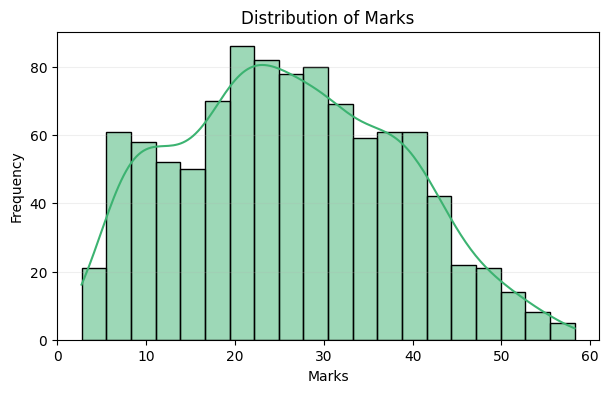

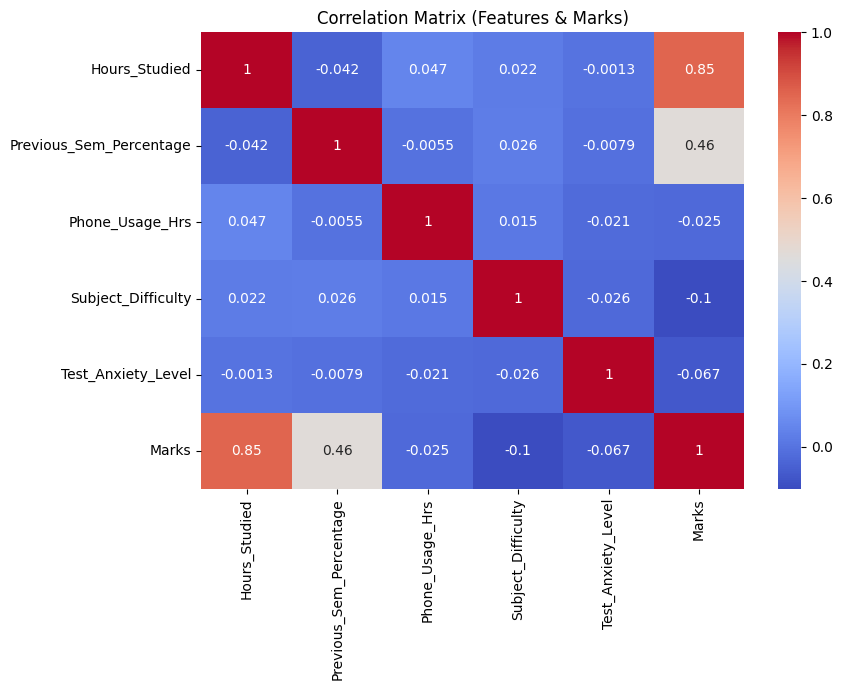

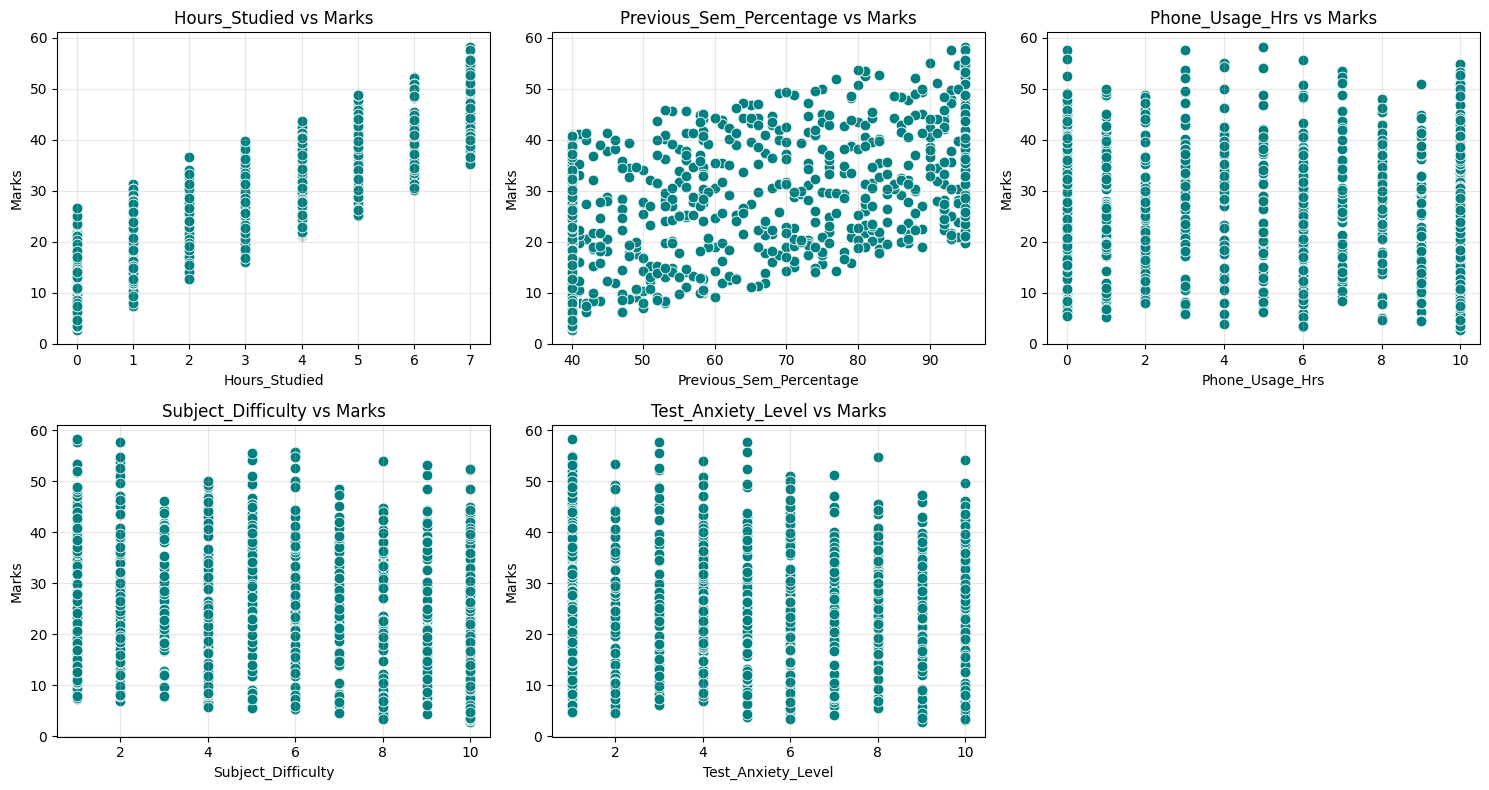

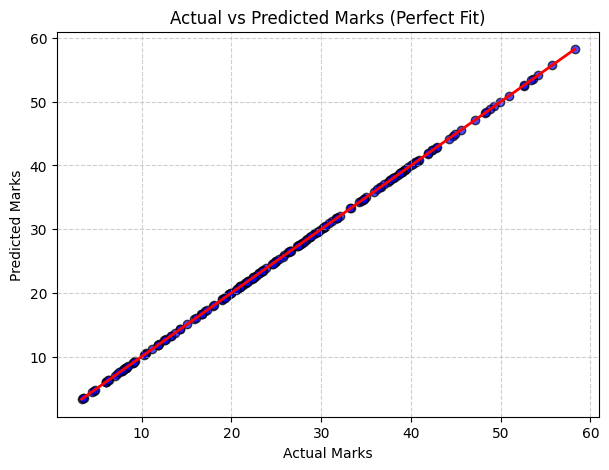

In [60]:
# --- 4. Exploratory Data Analysis (EDA) ---

# 1. Distribution of Marks
plt.figure(figsize=(7, 4))
sns.histplot(df['Marks'], bins=20, kde=True, color='mediumseagreen')
plt.title('Distribution of Marks')
plt.xlabel('Marks')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.2)
plt.show()

# 2. Correlation Heatmap including Marks
plt.figure(figsize=(9, 7))
corr_matrix = df[list(RANGES.keys()) + ['Marks']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix (Features & Marks)')
plt.tight_layout()
plt.show()

# 3. Scatter Plots: Each Feature vs. Marks
n_features = len(RANGES)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols
plt.figure(figsize=(5*n_cols, 4*n_rows))  # Sets the overall figure size dynamically based on the number of plots
for i, col in enumerate(RANGES.keys()):  # Iterates through each feature in RANGES.
    plt.subplot(n_rows, n_cols, i+1)  # Creates a subplot for each feature.
    sns.scatterplot(x=df[col], y=df['Marks'], color='teal', edgecolor='w', s=60)
    plt.title(f'{col} vs Marks')
    plt.xlabel(col)
    plt.ylabel('Marks')
    plt.grid(alpha=0.3)
plt.tight_layout()  # Adjusts spacing to prevent overlap.
plt.show()  # Renders the full grid of plots


# Define features (X) and target (y)
X = df[list(RANGES.keys())]   # all features in RANGES
y = df['Marks']               # target column

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# 4. Actual vs Predicted Marks
plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue', edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r-', linewidth=2)
plt.xlabel('Actual Marks')
plt.ylabel('Predicted Marks')
plt.title('Actual vs Predicted Marks (Perfect Fit)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [61]:
# --- 5. Train/Test Split and Model Training ---
features = list(RANGES.keys())
X = df[features]
y = df['Marks']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [62]:
# --- 6. Evaluation ---
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred)) #Lower RMSE = better model fit
mae = mean_absolute_error(y_test, y_pred) #Lower MAE = better accuracy.
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")
if r2 < 0.90: 
    print("Warning: R² is below 0.90. Check data quality or model setup.")

RMSE: 0.00
MAE: 0.00
R²: 1.0000


In [63]:
# Cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print(f"Cross-validated R² scores: {cv_scores}")
print(f"Average R²: {cv_scores.mean():.4f}")


Cross-validated R² scores: [1. 1. 1. 1. 1.]
Average R²: 1.0000


In [64]:
# --- 8. Save Model ---
joblib.dump(model, 'student_marks_model.pkl')
print("[INFO] Model saved as student_marks_model.pkl")

[INFO] Model saved as student_marks_model.pkl


In [65]:
# --- 9. User Prediction Prompt ---
user_input = input("Do you want to predict marks for a new student? (y/n): ").strip().lower()

if user_input == 'y':
    user_data = {}
    print("\nPlease enter the following details for the student:\n")
    
    for col in features:
        lo, hi = RANGES[col]
        while True:
            try:
                val = float(input(f"- {col.replace('_', ' ')} (range {lo} to {hi}): "))
                if lo <= val <= hi:
                    user_data[col] = val
                    break
                else:
                    print(f"  ⚠️ Value must be between {lo} and {hi}. Please try again.")
            except ValueError:
                print("  ⚠️ Invalid input. Please enter a number.")
    
    input_df = pd.DataFrame([user_data])
    
    # Clip values just in case
    for col, (lo, hi) in RANGES.items():
        input_df[col] = input_df[col].clip(lo, hi)
    
    pred = model.predict(input_df)[0]
    pred = np.clip(pred, 0, 100)
    print(f"\n🎯 Predicted Marks for the student: {pred:.2f}")

    


Please enter the following details for the student:


🎯 Predicted Marks for the student: 72.55
